In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_rule_based_series_numeric_index(
    n=500,
    trend_type='linear',           # 'linear', 'exponential', or None
    trend_strength=0.05,
    seasonality=True,
    seasonal_period=50,
    seasonal_amplitude=10,
    seasonal_type='additive',      # 'additive' or 'multiplicative'
    noise_std=2.0,
    changepoint_location=None,     # e.g., 300
    changepoint_magnitude=20,
    outlier_indices=None,          # list of indices like [100, 200]
    outlier_magnitude=15,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    t = np.arange(n)

    # Trend component
    if trend_type == 'linear':
        trend = trend_strength * t
    elif trend_type == 'exponential':
        trend = np.exp(trend_strength * t / n)
    else:
        trend = np.zeros(n)

    # Seasonal component
    if seasonality:
        seasonal = seasonal_amplitude * np.sin(2 * np.pi * t / seasonal_period)
    else:
        seasonal = np.zeros(n)

    # Base signal
    if seasonal_type == 'additive':
        base_signal = trend + seasonal
    elif seasonal_type == 'multiplicative':
        base_signal = (trend + 1) * (1 + seasonal / seasonal_amplitude)
    else:
        base_signal = trend

    # Changepoint
    if changepoint_location is not None and 0 < changepoint_location < n:
        base_signal[changepoint_location:] += changepoint_magnitude

    # Noise
    noise = np.random.normal(0, noise_std, size=n)
    series = base_signal + noise

    # Outliers
    if outlier_indices is not None:
        for idx in outlier_indices:
            if 0 <= idx < n:
                series[idx] += np.random.choice([-1, 1]) * outlier_magnitude

    # Assemble DataFrame
    df = pd.DataFrame({
        'value': series,
        'trend': trend,
        'seasonal': seasonal,
        'noise': noise
    }, index=t)

    return df

# Generate the updated version
df_numeric_index = generate_rule_based_series_numeric_index(
    n=500,
    trend_type='linear',
    seasonality=True,
    seasonal_type='additive',
    seasonal_period=50,
    changepoint_location=None,
    outlier_indices=[120, 250, 400],
    seed=42
)

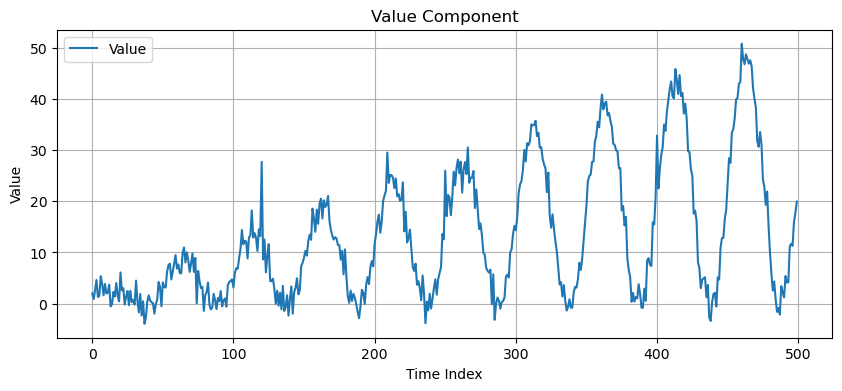

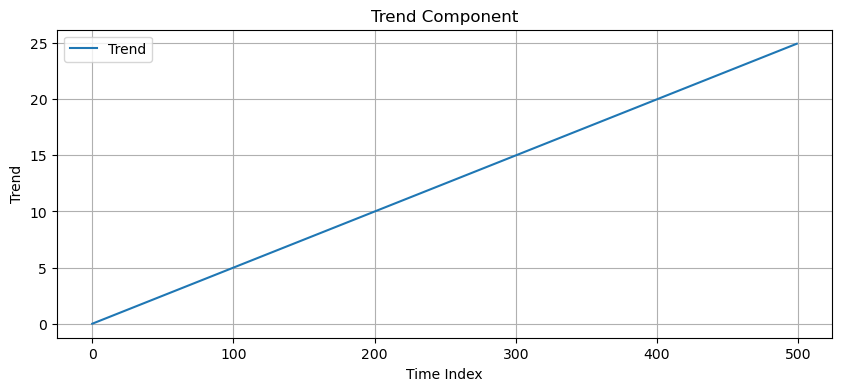

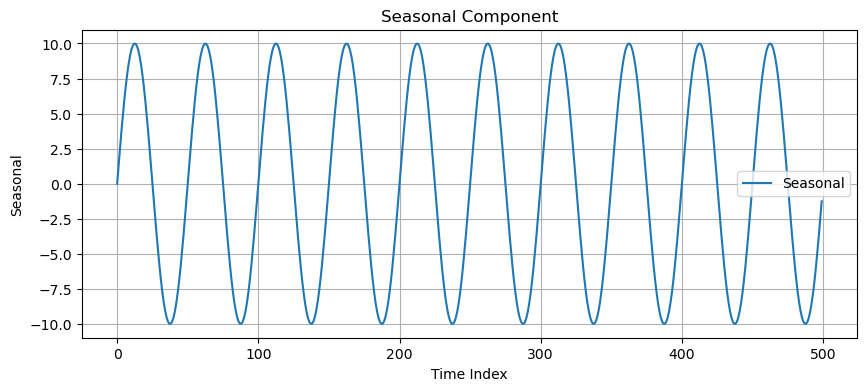

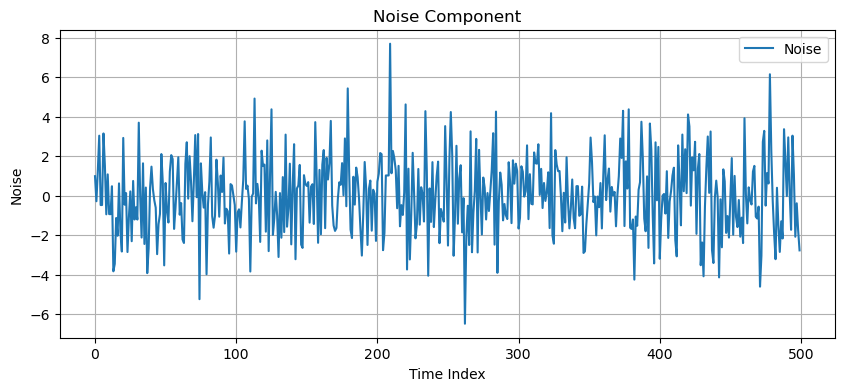

In [12]:
# Extract components
t = df_numeric_index.index
value = df_numeric_index['value']
trend = df_numeric_index['trend']
seasonal = df_numeric_index['seasonal']
noise = df_numeric_index['noise']

# Create individual plots
figures = {}
components = {'Value': value, 'Trend': trend, 'Seasonal': seasonal, 'Noise': noise}

for name, component in components.items():
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, component, label=name)
    ax.set_title(f"{name} Component")
    ax.set_xlabel("Time Index")
    ax.set_ylabel(name)
    ax.grid(True)
    ax.legend()
    figures[name] = fig

plt.show()


In [13]:
from statsmodels.tsa.arima_process import ArmaProcess

def generate_stochastic_series(
    n=500,
    ar_params=[0.75],          # AR coefficients (e.g., AR(1): [0.75])
    ma_params=[-0.25],         # MA coefficients (e.g., MA(1): [-0.25])
    d=0,                       # Differencing order (I(d) component)
    noise_std=1.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Add leading 1 for statsmodels convention
    ar = np.r_[1, -np.array(ar_params)]
    ma = np.r_[1, np.array(ma_params)]

    arma_process = ArmaProcess(ar, ma)

    # Generate ARMA sample
    arma_sample = arma_process.generate_sample(nsample=n + d, scale=noise_std)

    # Apply differencing if needed
    if d > 0:
        for _ in range(d):
            arma_sample = np.cumsum(arma_sample)

    # Create DataFrame
    df_stochastic = pd.DataFrame({
        'value': arma_sample[d:]
    }, index=np.arange(n))

    return df_stochastic

# Generate example ARIMA(1,1,1) process
df_stochastic_example = generate_stochastic_series(
    n=500,
    ar_params=[0.75],
    ma_params=[-0.25],
    d=1,
    noise_std=1.0,
    seed=42
)

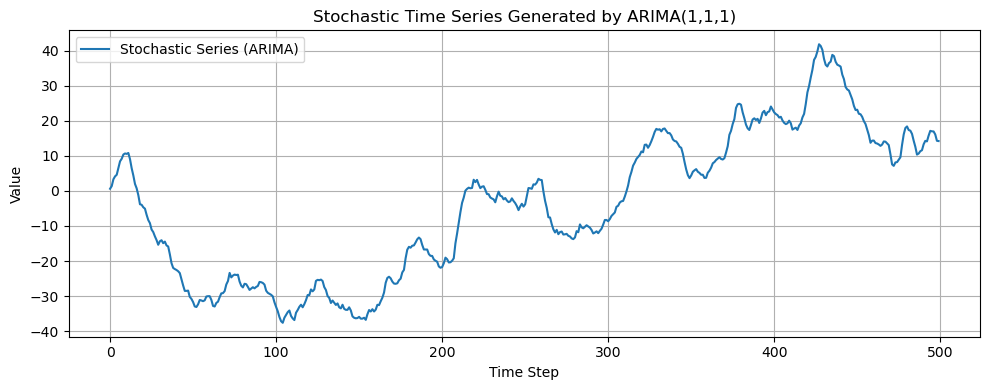

In [15]:
# Plot the ARIMA-generated stochastic time series
plt.figure(figsize=(10, 4))
plt.plot(df_stochastic_example.index, df_stochastic_example['value'], label="Stochastic Series (ARIMA)")
plt.title("Stochastic Time Series Generated by ARIMA(1,1,1)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


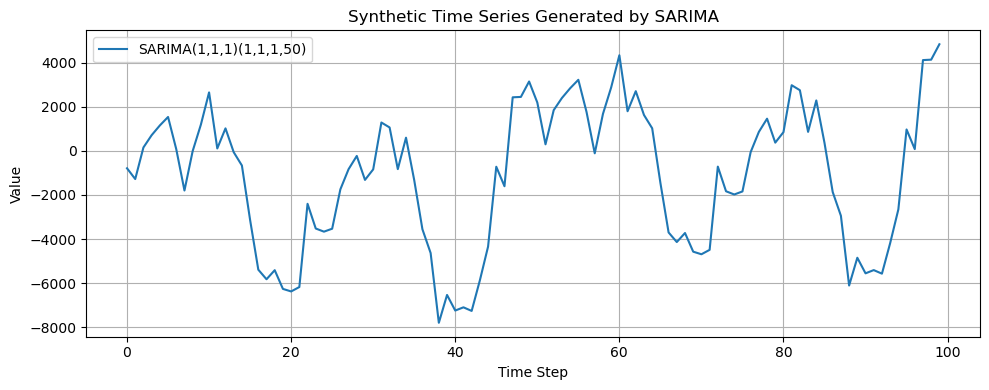

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fixing the simulation by first fitting a model to get initial parameters
def generate_sarima_series_fixed(
    n=500,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 50),
    noise_std=1.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Simulate white noise as a placeholder to fit initial model
    noise = np.random.normal(scale=noise_std, size=n)

    # Fit SARIMA model to get parameters
    model = SARIMAX(
        endog=noise,
        order=order,
        seasonal_order=seasonal_order,
        trend='n',
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fit_result = model.fit(disp=False)

    # Simulate using the fitted parameters
    simulated = model.simulate(params=fit_result.params, nsimulations=n)
    df_sarima = pd.DataFrame({'value': simulated}, index=np.arange(n))
    return df_sarima

# Generate SARIMA data
df_sarima_fixed = generate_sarima_series_fixed(
    n=100,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 50),
    noise_std=1.0,
    seed=42
)

# Plot the generated SARIMA series
plt.figure(figsize=(10, 4))
plt.plot(df_sarima_fixed.index, df_sarima_fixed['value'], label="SARIMA(1,1,1)(1,1,1,50)")
plt.title("Synthetic Time Series Generated by SARIMA")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

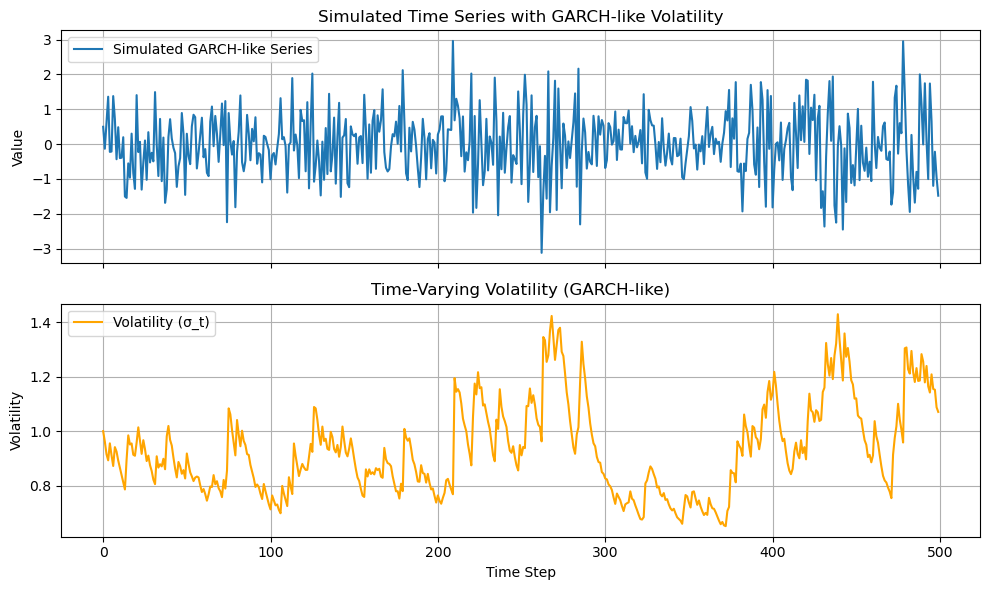

In [21]:
from arch import arch_model

# Manual GARCH(1,1)-like simulation without using `arch` library

def simulate_garch_like_process(n=500, omega=0.05, alpha=0.1, beta=0.85, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initialize arrays
    y = np.zeros(n)
    sigma2 = np.zeros(n)
    eps = np.random.normal(0, 1, n)

    # Set initial variance
    sigma2[0] = omega / (1 - alpha - beta)
    y[0] = np.sqrt(sigma2[0]) * eps[0]

    # Recursively generate the process
    for t in range(1, n):
        sigma2[t] = omega + alpha * y[t-1]**2 + beta * sigma2[t-1]
        y[t] = np.sqrt(sigma2[t]) * eps[t]

    df_garch_like = pd.DataFrame({
        'value': y,
        'volatility': np.sqrt(sigma2)
    }, index=np.arange(n))

    return df_garch_like

# Generate the GARCH-like series
df_garch_like = simulate_garch_like_process(n=500, omega=0.05, alpha=0.1, beta=0.85, seed=42)

# Plot the value and volatility
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(df_garch_like.index, df_garch_like['value'], label='Simulated GARCH-like Series')
axs[0].set_title("Simulated Time Series with GARCH-like Volatility")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(df_garch_like.index, df_garch_like['volatility'], color='orange', label='Volatility (σ_t)')
axs[1].set_title("Time-Varying Volatility (GARCH-like)")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Volatility")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


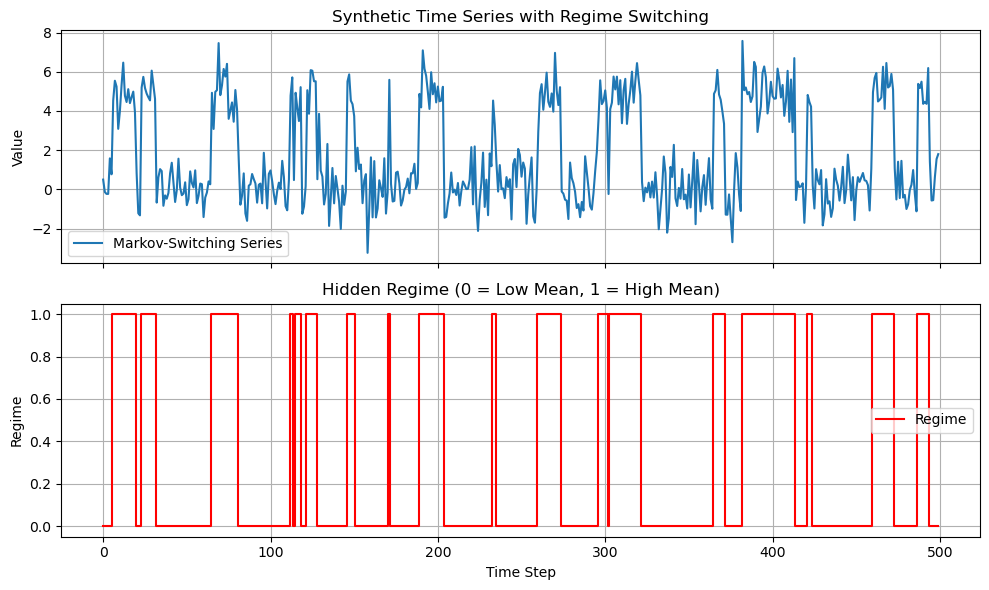

In [22]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

def simulate_markov_switching_series(n=500, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Simulate two regimes:
    # Regime 0: low mean
    # Regime 1: high mean
    regimes = np.zeros(n, dtype=int)
    values = np.zeros(n)
    
    # Transition probabilities
    p00 = 0.95  # Prob of staying in Regime 0
    p11 = 0.90  # Prob of staying in Regime 1

    current_regime = 0
    for t in range(n):
        regimes[t] = current_regime
        if current_regime == 0:
            values[t] = np.random.normal(loc=0, scale=1)
            current_regime = 0 if np.random.rand() < p00 else 1
        else:
            values[t] = np.random.normal(loc=5, scale=1)
            current_regime = 1 if np.random.rand() < p11 else 0

    df_markov = pd.DataFrame({
        'value': values,
        'regime': regimes
    }, index=np.arange(n))

    return df_markov

# Generate Markov-switching series
df_markov_switching = simulate_markov_switching_series(n=500, seed=42)

# Plot the Markov-switching series
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(df_markov_switching.index, df_markov_switching['value'], label='Markov-Switching Series')
axs[0].set_title("Synthetic Time Series with Regime Switching")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].grid(True)

axs[1].step(df_markov_switching.index, df_markov_switching['regime'], color='red', where='mid', label='Regime')
axs[1].set_title("Hidden Regime (0 = Low Mean, 1 = High Mean)")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Regime")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


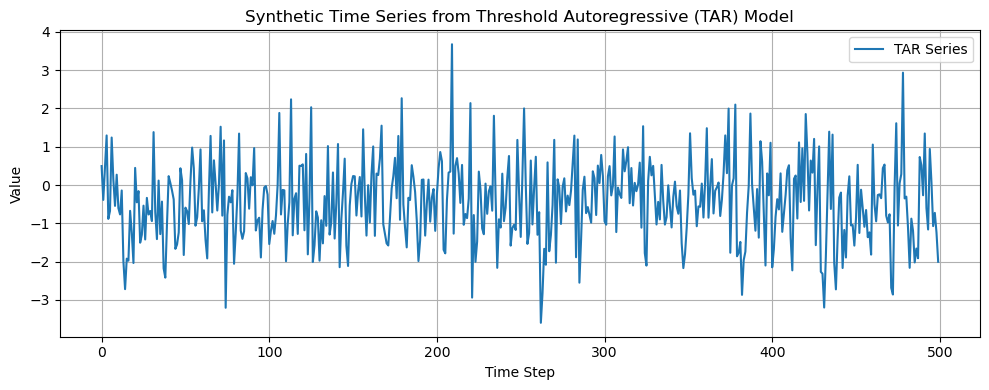

In [23]:
def simulate_tar_series(n=500, threshold=0.0, phi_low=0.5, phi_high=-0.5, noise_std=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    y = np.zeros(n)
    eps = np.random.normal(0, noise_std, size=n)

    # Initialize first value
    y[0] = eps[0]

    # Generate TAR process
    for t in range(1, n):
        if y[t-1] < threshold:
            y[t] = phi_low * y[t-1] + eps[t]
        else:
            y[t] = phi_high * y[t-1] + eps[t]

    df_tar = pd.DataFrame({
        'value': y
    }, index=np.arange(n))

    return df_tar

# Simulate TAR process
df_tar = simulate_tar_series(n=500, threshold=0.0, phi_low=0.5, phi_high=-0.5, noise_std=1.0, seed=42)

# Plot TAR series
plt.figure(figsize=(10, 4))
plt.plot(df_tar.index, df_tar['value'], label="TAR Series")
plt.title("Synthetic Time Series from Threshold Autoregressive (TAR) Model")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


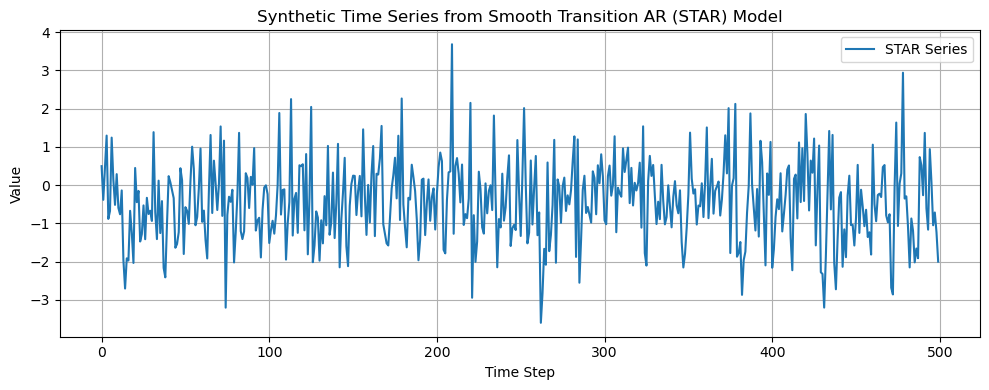

In [24]:
def simulate_star_series(
    n=500,
    threshold=0.0,
    phi_low=0.5,
    phi_high=-0.5,
    gamma=10.0,
    noise_std=1.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    y = np.zeros(n)
    eps = np.random.normal(0, noise_std, size=n)

    # Initialize the first value
    y[0] = eps[0]

    for t in range(1, n):
        transition = 1 / (1 + np.exp(-gamma * (y[t-1] - threshold)))
        phi = (1 - transition) * phi_low + transition * phi_high
        y[t] = phi * y[t-1] + eps[t]

    df_star = pd.DataFrame({'value': y}, index=np.arange(n))
    return df_star

# Simulate STAR series
df_star = simulate_star_series(
    n=500,
    threshold=0.0,
    phi_low=0.5,
    phi_high=-0.5,
    gamma=10.0,
    noise_std=1.0,
    seed=42
)

# Plot the STAR series
plt.figure(figsize=(10, 4))
plt.plot(df_star.index, df_star['value'], label="STAR Series")
plt.title("Synthetic Time Series from Smooth Transition AR (STAR) Model")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


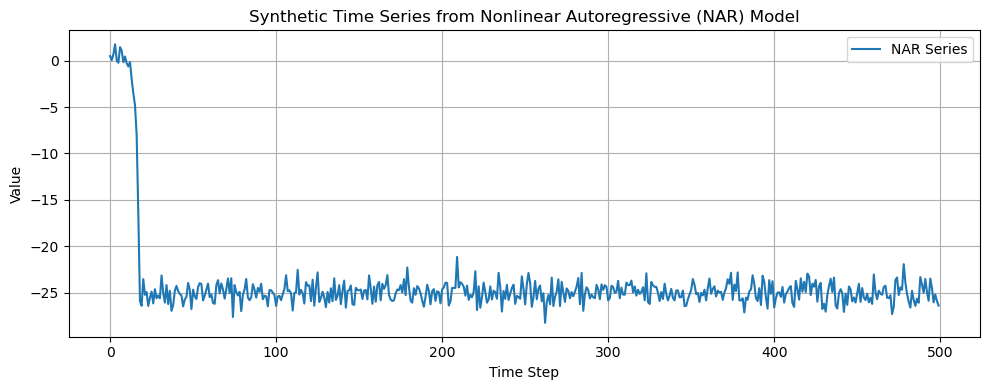

In [35]:
def simulate_nar_series_safe(n=500, degree=2, noise_std=1.0, coef_range=(0.5, -0.2), seed=None):
    if seed is not None:
        np.random.seed(seed)

    y = np.zeros(n)
    eps = np.random.normal(0, noise_std, size=n)

    # Initialize first value
    y[0] = eps[0]

    # Coefficients for polynomial terms (linear to degree)
    coefs = np.linspace(coef_range[0], coef_range[1], num=degree)

    for t in range(1, n):
        past_value = y[t - 1]

        # Prevent extreme growth
        past_value = np.clip(past_value, -10, 10)

        # Compute polynomial terms manually
        terms = np.array([past_value ** d for d in range(1, degree + 1)])
        y[t] = np.dot(coefs, terms) + eps[t]

    df_nar = pd.DataFrame({'value': y}, index=np.arange(n))
    return df_nar

# Simulate safe NAR series
df_nar_safe = simulate_nar_series_safe(n=500, degree=2, noise_std=1.0, coef_range=(0.5, -0.2), seed=42)

# Plot the NAR series
plt.figure(figsize=(10, 4))
plt.plot(df_nar_safe.index, df_nar_safe['value'], label="NAR Series")
plt.title("Synthetic Time Series from Nonlinear Autoregressive (NAR) Model")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


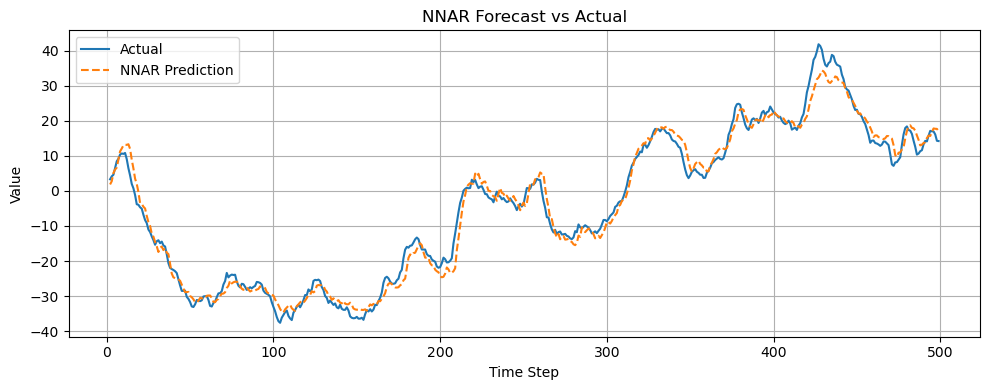

In [38]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def create_lag_features(series, lags=0):
    """Generate lag features for time series."""
    df = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df.dropna(inplace=True)
    return df

def train_nnar_model(series, lags=5, hidden_layer_sizes=(10,), seed=None):
    """Train NNAR model on a time series."""
    df_lags = create_lag_features(series, lags)
    X = df_lags.drop(columns=['y']).values
    y = df_lags['y'].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, random_state=seed, max_iter=1000)
    model.fit(X_scaled, y)

    # Forecast
    y_pred = model.predict(X_scaled)

    return y[lags:], y_pred, df_lags.index[lags:]

# Use ARIMA-generated series for testing
series = df_stochastic_example['value'].values
y_true, y_pred, idx = train_nnar_model(series, lags=1, hidden_layer_sizes=(10,), seed=42)

# Align lengths explicitly
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]
idx = idx[:min_len]

# Plot corrected NNAR forecast vs actual
plt.figure(figsize=(10, 4))
plt.plot(idx, y_true, label='Actual')
plt.plot(idx, y_pred, label='NNAR Prediction', linestyle='--')
plt.title("NNAR Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


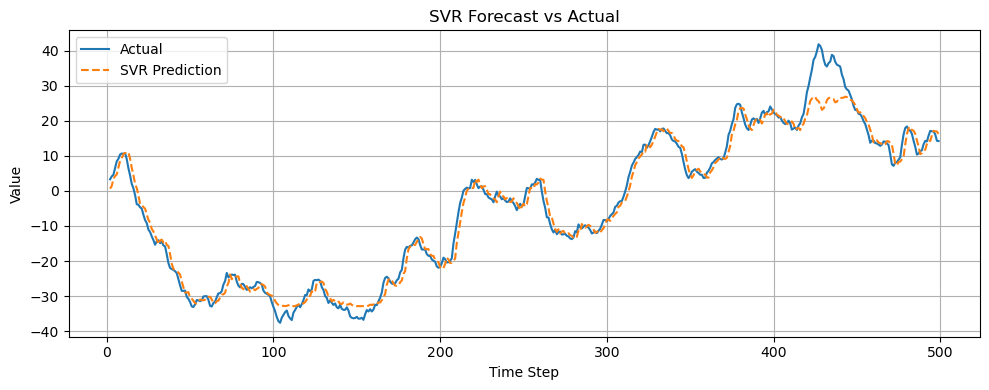

In [40]:
from sklearn.svm import SVR

def train_svr_model(series, lags=5, kernel='rbf', C=1.0, epsilon=0.1, seed=None):
    """Train SVR model on a time series."""
    df_lags = create_lag_features(series, lags)
    X = df_lags.drop(columns=['y']).values
    y = df_lags['y'].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train SVR model
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_scaled, y)

    # Predict
    y_pred = model.predict(X_scaled)

    return y[lags:], y_pred, df_lags.index[lags:]

# Use the same ARIMA-based data
series = df_stochastic_example['value'].values
y_true_svr, y_pred_svr, idx_svr = train_svr_model(series, lags=1, C=1.0, epsilon=0.1, seed=42)

# Align arrays
min_len = min(len(y_true_svr), len(y_pred_svr), len(idx_svr))
y_true_svr = y_true_svr[:min_len]
y_pred_svr = y_pred_svr[:min_len]
idx_svr = idx_svr[:min_len]

# Plot SVR forecast vs actual
plt.figure(figsize=(10, 4))
plt.plot(idx_svr, y_true_svr, label='Actual')
plt.plot(idx_svr, y_pred_svr, label='SVR Prediction', linestyle='--')
plt.title("SVR Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


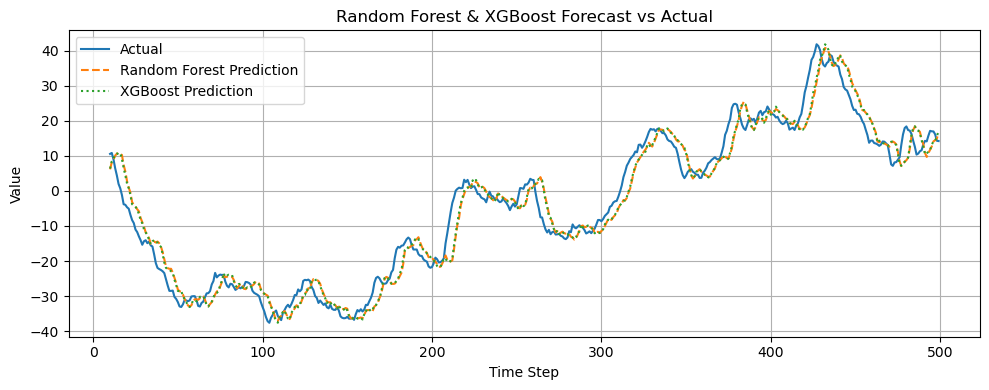

In [44]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def train_rf_xgb_models(series, lags=5, seed=42):
    df_lags = create_lag_features(series, lags)
    X = df_lags.drop(columns=['y']).values
    y = df_lags['y'].values

    # Standardize features (optional for trees, but consistent here)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf_model.fit(X_scaled, y)
    y_pred_rf = rf_model.predict(X_scaled)

    # Train XGBoost
    xgb_model = XGBRegressor(n_estimators=100, random_state=seed, verbosity=0)
    xgb_model.fit(X_scaled, y)
    y_pred_xgb = xgb_model.predict(X_scaled)

    return y[lags:], y_pred_rf, y_pred_xgb, df_lags.index[lags:]

# Use the same ARIMA-generated series
series = df_stochastic_example['value'].values
y_true_tree, y_pred_rf, y_pred_xgb, idx_tree = train_rf_xgb_models(series, lags=5, seed=42)

# Align arrays
min_len = min(len(y_true_tree), len(y_pred_rf), len(y_pred_xgb), len(idx_tree))
y_true_tree = y_true_tree[:min_len]
y_pred_rf = y_pred_rf[:min_len]
y_pred_xgb = y_pred_xgb[:min_len]
idx_tree = idx_tree[:min_len]

# Plot both models
plt.figure(figsize=(10, 4))
plt.plot(idx_tree, y_true_tree, label='Actual')
plt.plot(idx_tree, y_pred_rf, label='Random Forest Prediction', linestyle='--')
plt.plot(idx_tree, y_pred_xgb, label='XGBoost Prediction', linestyle=':')
plt.title("Random Forest & XGBoost Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_50408/844384562.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391816234/work/torch/csrc/utils/tensor_new.cpp:264.)
  self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(1)


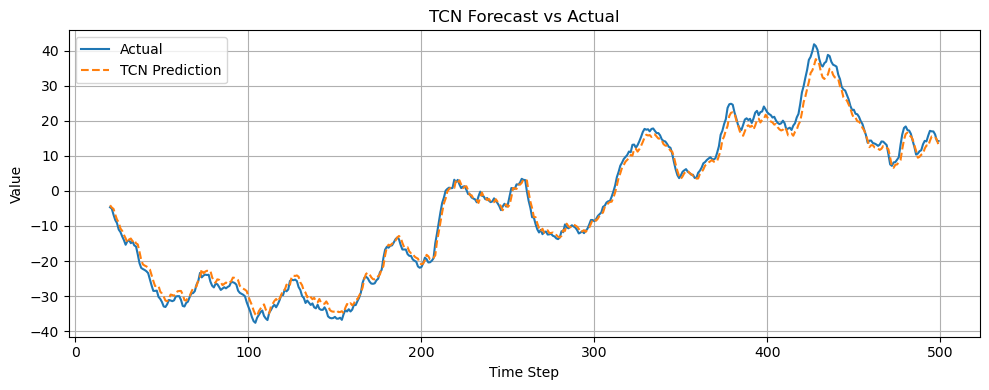

In [45]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Define TCN block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return self.dropout(out)

# Define simple TCN model
class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, padding))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        out = self.network(x)
        out = out[:, :, -1]
        return self.linear(out).squeeze()

# Dataset wrapper
class SequenceDataset(Dataset):
    def __init__(self, series, lags=20):
        self.X = []
        self.y = []
        for i in range(lags, len(series)):
            self.X.append(series[i-lags:i])
            self.y.append(series[i])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare dataset
lags = 20
series = df_stochastic_example['value'].values
dataset = SequenceDataset(series, lags=lags)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize and train model
tcn_model = TCN(input_size=1, num_channels=[16, 16])
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train for a few epochs
for epoch in range(10):
    tcn_model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = tcn_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate (in-sample predictions)
tcn_model.eval()
X_all = torch.tensor([series[i-lags:i] for i in range(lags, len(series))],
                     dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    preds_tcn = tcn_model(X_all).numpy()
true_tcn = series[lags:]

# Plot TCN results
plt.figure(figsize=(10, 4))
plt.plot(np.arange(lags, len(series)), true_tcn, label='Actual')
plt.plot(np.arange(lags, len(series)), preds_tcn, label='TCN Prediction', linestyle='--')
plt.title("TCN Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


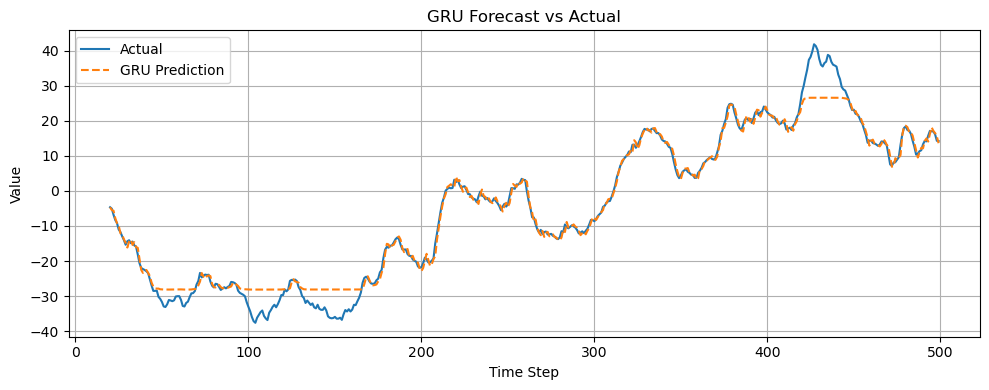

In [50]:
# Define GRU-based model
class GRUForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# Prepare GRU dataset
class GRUDataset(Dataset):
    def __init__(self, series, lags=20):
        self.X = []
        self.y = []
        for i in range(lags, len(series)):
            self.X.append(series[i-lags:i])
            self.y.append(series[i])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
lags = 20
series = df_stochastic_example['value'].values
dataset_gru = GRUDataset(series, lags=lags)
loader_gru = DataLoader(dataset_gru, batch_size=32, shuffle=True)

# Initialize GRU model
gru_model = GRUForecast(input_size=1, hidden_size=32, num_layers=1)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train GRU
for epoch in range(100):
    gru_model.train()
    for X_batch, y_batch in loader_gru:
        optimizer.zero_grad()
        output = gru_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate GRU model
gru_model.eval()
X_all_gru = torch.tensor([series[i-lags:i] for i in range(lags, len(series))],
                         dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    preds_gru = gru_model(X_all_gru).numpy()
true_gru = series[lags:]

# Plot GRU predictions
plt.figure(figsize=(10, 4))
plt.plot(np.arange(lags, len(series)), true_gru, label='Actual')
plt.plot(np.arange(lags, len(series)), preds_gru, label='GRU Prediction', linestyle='--')
plt.title("GRU Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


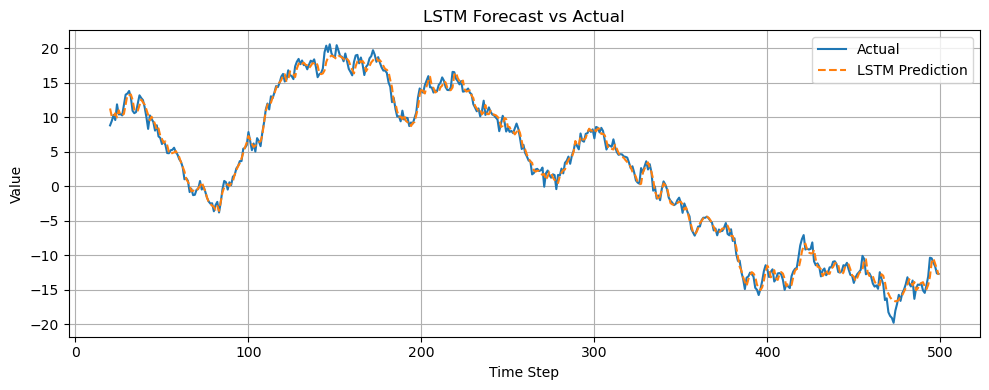

In [49]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# LSTM Forecasting Model
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# Dataset preparation
class LSTMDataset(Dataset):
    def __init__(self, series, lags=20):
        self.X = []
        self.y = []
        for i in range(lags, len(series)):
            self.X.append(series[i-lags:i])
            self.y.append(series[i])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Simulate ARIMA-like data
np.random.seed(0)
data = np.cumsum(np.random.randn(500))  # like ARIMA(0,1,0)

# Train setup
lags = 20
dataset = LSTMDataset(data, lags=lags)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = LSTMForecast()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train
for epoch in range(100):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

# Predict
model.eval()
X_all = torch.tensor([data[i-lags:i] for i in range(lags, len(data))], dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y_pred = model(X_all).numpy()

# Plot
y_true = data[lags:]
plt.figure(figsize=(10, 4))
plt.plot(np.arange(lags, len(data)), y_true, label='Actual')
plt.plot(np.arange(lags, len(data)), y_pred, label='LSTM Prediction', linestyle='--')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:07 - cmdstanpy - INFO - Chain [1] done processing


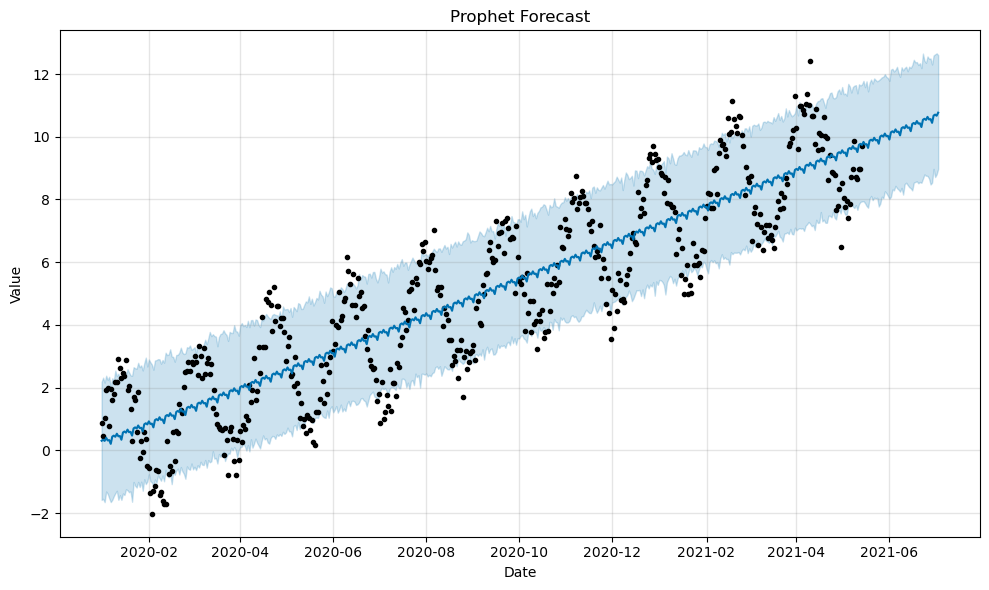

In [53]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Simulate synthetic data
np.random.seed(0)
n = 500
trend = np.linspace(0, 10, n)
seasonality = 2 * np.sin(2 * np.pi * np.arange(n) / 50)
noise = np.random.normal(0, 0.5, n)
y = trend + seasonality + noise

# Prepare data for Prophet
df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=n, freq='D'),
    'y': y
})

# Fit Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(df)

# Forecast 50 future days
future = model.make_future_dataframe(periods=50)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


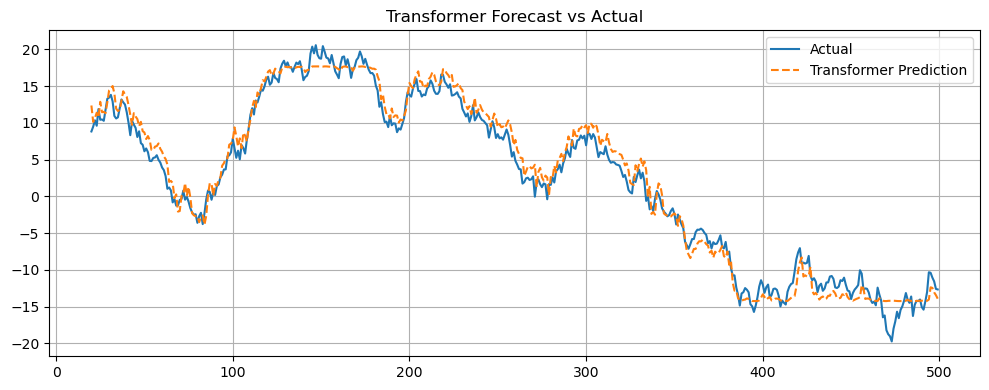

In [55]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Synthetic data
np.random.seed(0)
series = np.cumsum(np.random.randn(500))  # ARIMA-like

# Prepare dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window=20):
        self.X, self.y = [], []
        for i in range(window, len(series)):
            self.X.append(series[i-window:i])
            self.y.append(series[i])
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer model
class TransformerForecast(nn.Module):
    def __init__(self, input_dim=1, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output_fc(x[:, -1, :]).squeeze()

# Data and model
window = 20
dataset = TimeSeriesDataset(series, window)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = TransformerForecast()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training
for epoch in range(50):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()

# In-sample prediction
model.eval()
X_all = torch.tensor([series[i-window:i] for i in range(window, len(series))],
                     dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    preds = model(X_all).numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(window, len(series)), series[window:], label='Actual')
plt.plot(np.arange(window, len(series)), preds, label='Transformer Prediction', linestyle='--')
plt.title("Transformer Forecast vs Actual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
